<b style="color: red;">TODO </b>
1) Add signatures from dataset1 to dataset2 mainly related to background color <br>
2) Understand how to setup tensorflow GPU. Currently using Tensorflow CPU

<p style="color: red;">
Tensor flow install error

  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
ERROR: catboost 0.24.4 requires plotly, which is not installed.
ERROR: tensorflow 1.15.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.4.1 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.4.0 which is incompatible.
ERROR: tensorflow-gpu 1.15.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: tensorflow-gpu 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.4.1 which is incompatible.
ERROR: tensorflow-gpu 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.4.0 which is incompatible.
ERROR: astroid 2.3.3 has requirement wrapt==1.11.*, but you'll have wrapt 1.12.1 which is incompatible.
Installing collected packages: six, absl-py, gast, grpcio, numpy, oauthlib, requests-oauthlib, rsa, cachetools, google-auth, google-auth-oauthlib, tensorboard-plugin-wit, wheel, tensorboard, wrapt, typing-extensions, keras-preprocessing, astunparse, opt-einsum, tensorflow-estimator, flatbuffers, tensorflow-cpu
  Attempting uninstall: six

</p>

<b>Tuning </b><p>
layer.trainable = True yields around ~77% accuracy

To try
1) Increase input shape to higher than 224   ==> imageDimensions = (224,224,3)=77%   (512,224,3)= <br> 
2) Add one more FC Layer ===> 4096 did not help <br>
3) Try Resnet<br>

VGG16 and VGG19 - yields similar performance.
    
</p>

Trying retraining all layers instead of using exsisting weights. 78% accuracy!!

In [3]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import math

<b> Load training and test data </b>

In [4]:
basepath = "/notebooks/capstone/dataset/dataset2/sign_data"
data_train = pd.read_csv(basepath + "/train/train_clean.csv")
print(data_train.head())
print(data_train.shape)

     company  personId person    fileName relPath  Genuine  forged
0  Acme Corp         1   Erin  001_01.PNG     001        1       0
1  Acme Corp         1   Erin  001_02.PNG     001        1       0
2  Acme Corp         1   Erin  001_03.PNG     001        1       0
3  Acme Corp         1   Erin  001_04.PNG     001        1       0
4  Acme Corp         1   Erin  001_05.PNG     001        1       0
(1649, 7)


In [74]:
data_test = pd.read_csv(basepath + "/test/test_clean.csv")
print(data_test.head())
print(data_test.shape)

         company  personId person    fileName relPath  genuine  forged
0  AI Novice Inc        49     IE  01_049.png     049        1       0
1  AI Novice Inc        49     IE  02_049.png     049        1       0
2  AI Novice Inc        49     IE  03_049.png     049        1       0
3  AI Novice Inc        49     IE  04_049.png     049        1       0
4  AI Novice Inc        49     IE  05_049.png     049        1       0
(500, 7)


In [75]:
img = cv2.imread(basepath + "/train/" + data_train.iloc[1]["relPath"] + "/" + data_train.iloc[1]["fileName"])

# !!! Crashe kernel
# cv2.imshow("image1",img)
# k = cv2.waitKey(0) & 0xFF
# if k == 27:         # wait for ESC key to exit
#     cv2.destroyAllWindows()

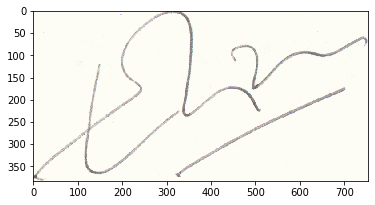

In [76]:
plt.imshow(img)

<b>Prepare Model Architecture</b>

In [77]:
import tensorflow as tf
from tensorflow.keras import applications as kapps
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg16 import preprocess_input

In [78]:
imageDimensions = (224,224,3)
vgg16_model = kapps.VGG16(include_top=False, weights="imagenet", input_tensor=None, input_shape=imageDimensions, pooling=None, classifier_activation="softmax")

In [79]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [80]:
#disable training for all conv and pooling layers
layers = vgg16_model.layers#[:20]
for layer in layers:
     layer.trainable = False

In [81]:
x = Flatten(input_shape=vgg16_model.output_shape[1:])(vgg16_model.output)
#fcLayers = Dense(4096, activation='relu')(x)
fcLayers = Dense(9096, activation='relu')(x)
predictions = Dense(1, activation='softmax')(fcLayers)

In [82]:

model = Model(inputs=vgg16_model.input, outputs=predictions)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [83]:
model.compile(optimizer="Adam", loss="binary_crossentropy",  metrics=['accuracy'])

<b>Prepare training data</b>

In [84]:
def getImages(basePath, imageFilesDf, imageDimensions):
    images=[]
    for imgFileIdx in imageFilesDf.index:
        img_path = basePath + "/" + imageFilesDf.loc[imgFileIdx]["relPath"] + "/" + imageFilesDf.loc[imgFileIdx]["fileName"]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (imageDimensions[1],imageDimensions[0]), interpolation=cv2.INTER_CUBIC)
        #img = img/255 - resulted in a drop in accuracy
        #img=preprocess_input(img)
        images.append(img)
    return np.array(images);

In [85]:
data_train_imgs = getImages(basepath + "/train", data_train,imageDimensions[:2]);
print(len(data_train_imgs))

1649


In [86]:
data_train_labels = data_train["Genuine"]
print(len(data_train_labels))

1649


<b> Train Model </b>

In [87]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=1)

early_stop=[earlyStopping]

In [88]:
EPOCHS = 3 #20
BS = 32 #64
progess = model.fit(data_train_imgs,data_train_labels, batch_size=BS,epochs=EPOCHS, callbacks=early_stop,validation_split=.3)

Epoch 1/3
37/37 [==============================] - 187s 5s/step - loss: 101.0520 - accuracy: 0.7781 - val_loss: 10.7710 - val_accuracy: 0.0000e+00
Epoch 2/3
37/37 [==============================] - 185s 5s/step - loss: 0.4444 - accuracy: 0.7571 - val_loss: 8.4284 - val_accuracy: 0.0000e+00
Epoch 3/3
37/37 [==============================] - 188s 5s/step - loss: 0.0115 - accuracy: 0.7776 - val_loss: 6.4991 - val_accuracy: 0.0000e+00


<b>Testing Model</b>

In [70]:
data_test_imgs = getImages(basepath + "/test", data_test,imageDimensions[:2]);
print(len(data_test_imgs))

500


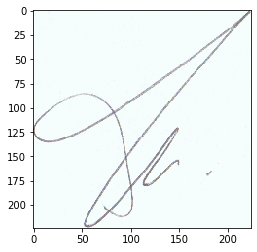

In [71]:
plt.imshow(data_test_imgs[2])

In [22]:
data_test_labels = data_test["genuine"]
print(len(data_test_labels))

500


In [58]:
pred_results = progess.model.predict(data_test_imgs)

In [36]:
from sklearn.metrics import classification_report

In [56]:
print(classification_report(pred_results, np.reshape(data_test_labels.values, (500,1))))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.50      0.67       500

    accuracy                           0.50       500
   macro avg       0.50      0.25      0.34       500
weighted avg       1.00      0.50      0.67       500



/opt/conda/envs/springboard/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [62]:
#np.reshape(data_test_labels.values, (-1,1))
#pred_results